In [196]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
import shutil


In [170]:
class data_processor():
    
    def __init__(self):
        self.years     = [2013, 2014, 2015, 2016, 2017, 2018]
        self.suppliers = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
        self.datas     = self.load_data()
        self.month_nums  = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        
    
    def load_data(self):
        datas = dict()
        for supplier in suppliers:
            datas['data_{}'.format(supplier)] = pd.read_csv('./Data/supplier_{}.csv'.format(supplier)) 
        
        return datas
    
    def get_december_data(self, datas):
        # getting the last day of december (31st) of each year except 2018
        
        training_12_all = []
        for key in datas.keys():
            training_12  = datas[key][ (datas[key]['month'] == 12) & \
                                      (datas[key]['year'].isin([2013, 2014, 2015,2016, 2017])) ].reset_index(drop = True)


            ### for cutting out all december days except the 31st
            training_12 = training_12.sort_values(['year', 'month','day']).reset_index(drop=True)

            #print(training_12['year'].value_counts())
            training_12_cut = []
            for i in range(1,6):
                training_12_cut.append(training_12.iloc[(744*i)-24:744*i])

            training_12_final = pd.concat(training_12_cut, axis = 0).reset_index(drop=True)
            #print(training_12_final['year'].value_counts())
            
            training_12_all.append(training_12_final)
            
        
        return training_12_all
    
    def get_jan_march_data(self, datas):
        
        training_1_3_all = []
        
        for key in datas.keys():  
            training_1_3 = datas[key][ (datas[key]['month'].isin([1,2,3])) & \
                             (datas[key]['year'].isin([2014, 2015, 2016, 2017, 2018])) ].reset_index(drop = True)
            
            training_1_3_all.append(training_1_3)
        
        return training_1_3_all
    
    def combine_data(self, training_12_all, training_1_3_all):
        
        combined_all = []
        
        assert len(training_12_all) == len(training_1_3_all), "december and jan-march data lengths should match"
        
        for i in range(len(training_12_all)):
            training = pd.concat([training_12_all[i], training_1_3_all[i]], axis = 0).reset_index(drop=True)
            training = training.sort_values(['year', 'month']).reset_index(drop=True)
            
            combined_all.append(training)
        
        return combined_all
    
    def separate_data(self, combined_data):
        # separate 12/31 - 3/31 for each pair of year (e.g. 2013-2014, 2014-2015, etc.)
        indices = []
        for year in self.years[1:]: # march of 2014-2018
            indices.append( combined_data[ (combined_data['year'] == year) & (combined_data['month'] == 3) &\
                           (combined_data['day'] == 31) & (combined_data['시간'] == 24)].index[0] )
        print(indices)
        training_sep = []
        last_idx = 0
        for idx in indices:
            idx = idx + 1 
            #if idx != training_A.shape[0] -1 else idx
            training_sep.append(combined_data[last_idx:idx][['공급량', 'year', 'month', 'day', '시간']])
            last_idx = idx
        
        return training_sep
    
    
    def make_scalers(self, combined_all):
        combined = combined_all[:]
        # change pandas dataframe to numpy ndarray
        for i in range(len(combined_all)): # loop through suppliers 
            supplier = combined[i]['구분'].iloc[0]
            assert supplier == self.suppliers[i], 'suppliers should match'
            combined[i] = combined[i][['공급량', 'year', 'month', 'day', '시간']].values
            #print(combined[i].shape)
            x_scaler = MinMaxScaler()
            y_scaler = MinMaxScaler()
            x_scaler.fit(combined[i])
            y_scaler.fit(combined[i][:, [0]])
            
            path_x = './Scalers/x_scaler_{}.pkl'.format(supplier)
            dump(x_scaler, open(path_x, 'wb'))
            path_y = './Scalers/y_scaler_{}.pkl'.format(supplier)
            dump(y_scaler, open(path_y, 'wb'))
            
        
    
    def create_LSTM_Input(self, data, seq_length, step_size):
        final_data = np.zeros((data.shape[0]-seq_length, int(seq_length/step_size), data.shape[1]))

        length = data.shape[0]

        for i in range(final_data.shape[0]):
            final_data[i] = data[i:i+seq_length:step_size]

        return final_data

    def create_LSTM_Output(self, data, seq_length):
        final_output = []
        length = data.shape[0]

        for i in range(seq_length, length):
            final_output.append(data[i])

        final_output = np.array(final_output)
        #final_output = np.expand_dims(final_output, axis = 1)

        return final_output

    
    def separate_data_to_lstm_input(self, sep_data, x_scaler, y_scaler, seq_length): 
        # need to make each chunck 12-3 into lstm inputs SEPARATELY
        lstm_input_lst = []
        lstm_output_lst = []
        for i in range(len(sep_data)):
            sep_values = sep_data[i].values
            x_norm = x_scaler.transform(sep_values)
            #[:,[0, 4]]
            y_norm = y_scaler.transform(sep_values[:, [0]])
            lstm_input_lst.append(self.create_LSTM_Input(x_norm, seq_length, 1))
            lstm_output_lst.append(self.create_LSTM_Output(y_norm, seq_length))


        lstm_input = np.concatenate(lstm_input_lst, axis = 0)
        lstm_output = np.concatenate(lstm_output_lst, axis = 0)
        
        return lstm_input, lstm_output
        



In [171]:
import os
os.getcwd()

'/Users/woojaebyun/Documents/Dacon_Gas_Prediction'

In [172]:
dp = data_processor()

In [173]:
dec_data = dp.get_december_data(dp.datas)
jan_march_data = dp.get_jan_march_data(dp.datas)

combined_all = dp.combine_data(dec_data, jan_march_data)

combined_all[0][['공급량', 'year', 'month', 'day', '시간']].values[:5,]

array([[1.901489e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        1.000000e+00],
       [1.706081e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        2.000000e+00],
       [1.533921e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        3.000000e+00],
       [1.611033e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        4.000000e+00],
       [1.792161e+03, 2.013000e+03, 1.200000e+01, 3.100000e+01,
        5.000000e+00]])

In [226]:
sep_data = dp.separate_data(combined_all[6])
print(combined_all[6].iloc[:5])

x_scaler = load(open('./Scalers/x_scaler_H.pkl', 'rb'))
y_scaler = load(open('./Scalers/y_scaler_H.pkl', 'rb'))
lstm_input, lstm_output = dp.separate_data_to_lstm_input(sep_data, x_scaler, y_scaler, 3)

print(lstm_input.shape)
print(lstm_output.shape)

[2183, 4367, 6575, 8759, 10943]
   Unnamed: 0         연월일  시간 구분      공급량  year  month  day
0        8736  2013-12-31   1  H  448.692  2013     12   31
1        8737  2013-12-31   2  H  383.316  2013     12   31
2        8738  2013-12-31   3  H  321.844  2013     12   31
3        8739  2013-12-31   4  H  334.348  2013     12   31
4        8740  2013-12-31   5  H  398.196  2013     12   31
(10929, 3, 5)
(10929, 1)


In [227]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(lstm_input, lstm_output, test_size = 0.2, random_state = 1311, shuffle=True)


In [189]:
import tensorflow as tf

from tensorflow.keras.layers import Reshape, Dense, Input, LSTM, Flatten, Concatenate, Bidirectional, BatchNormalization, Dropout, ReLU, Activation, ConvLSTM2D, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [228]:
input_x = Input(shape=(3,5)) #(sequence length, num of features) for LSTM; i.e. 50 minutes (sequence of 50 minutes)

x = LSTM(20, return_sequences=True)(input_x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)

x = LSTM(10, return_sequences=True)(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)

x = Flatten()(x)

x = Dense(32)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

output = Dense(1)(x)


model = Model(inputs = input_x, outputs = output)
model.compile(loss="mean_absolute_error", optimizer = Adam(lr=0.001)) 
model.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3, 5)]            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 3, 20)             2080      
_________________________________________________________________
batch_normalization_33 (Batc (None, 3, 20)             80        
_________________________________________________________________
activation_33 (Activation)   (None, 3, 20)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 3, 10)             1240      
_________________________________________________________________
batch_normalization_34 (Batc (None, 3, 10)             40        
_________________________________________________________________
activation_34 (Activation)   (None, 3, 10)             0  

/Users/woojaebyun/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [229]:
es = EarlyStopping(monitor='val_loss', mode = 'min' , patience = 10, verbose = 1)

path = './Models/training_{}'.format('H')
if os.path.isdir(path):
    shutil.rmtree(path)

os.makedirs(path, exist_ok = True)

file_path = path + '/Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min',verbose=1, \
                     save_best_only=True, save_weights_only=True)

hist = model.fit(train_x, train_y, batch_size = 128, epochs =30, validation_data = (valid_x, valid_y), callbacks = [es, mc])

Epoch 1/30


2021-10-21 22:41:28.735639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/69 [..............................] - ETA: 1:33 - loss: 0.3836

2021-10-21 22:41:28.987776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:29.021230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:29.076823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:29.122809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 0.1626

2021-10-21 22:41:31.168805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:31.233445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-21 22:41:31.255792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 4s 33ms/step - loss: 0.1626 - val_loss: 0.0439

Epoch 00001: val_loss improved from inf to 0.04386, saving model to ./Models/training_H/Epoch_001_Val_0.044.hdf5
Epoch 2/30
69/69 [==============================] - 2s 27ms/step - loss: 0.0794 - val_loss: 0.0921

Epoch 00002: val_loss did not improve from 0.04386
Epoch 3/30
69/69 [==============================] - 2s 27ms/step - loss: 0.0609 - val_loss: 0.1067

Epoch 00003: val_loss did not improve from 0.04386
Epoch 4/30
69/69 [==============================] - 2s 26ms/step - loss: 0.0492 - val_loss: 0.1041

Epoch 00004: val_loss did not improve from 0.04386
Epoch 5/30
69/69 [==============================] - 2s 26ms/step - loss: 0.0434 - val_loss: 0.1097

Epoch 00005: val_loss did not improve from 0.04386
Epoch 6/30
69/69 [==============================] - 2s 26ms/step - loss: 0.0390 - val_loss: 0.1048

Epoch 00006: val_loss did not improve from 0.04386
Epoch 7/30
69/69 [=========================

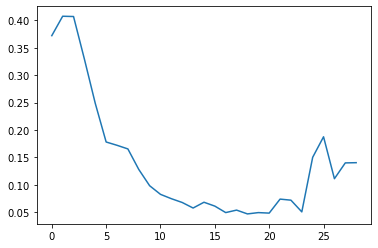

In [217]:
from matplotlib import pyplot as plt
plt.plot(hist.history['val_loss'])